# Spec2Vec - library matching
One very important use case for a spectral similariy measure is libarary matching.  
This means matching previously unseen/unknown spectra to known, annotated sepctra in a larger library.

In [1]:
# Locations
ROOT = "C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA"
PATH_SPEC2VEC = ROOT + "\\Spec2Vec\\code\\"
PATH_MS_DATA = ROOT + "\\Data\\GNPS_all\\"
PATH_SAVE_MODEL = ROOT + "\\Spec2Vec\\models_trained\\"
PATH_COMPUTED = ROOT + "\\Spec2Vec\\computed_results\\"
PATH_OUTPUT = ROOT + "\\Spec2Vec\\output_plots\\"

In [2]:
import numpy as np
import sys
sys.path.insert(0, PATH_SPEC2VEC)

In [3]:
import helper_functions as functions
import MS_functions
import MS_similarity_classical as MS_sim_classic
from similarity_measure import SimilarityMeasures
from plotting_functions import plot_precentile

from scipy import spatial

### Load filtered allGNPS_positive dataset OR:  Import& filter allGNPS_positive dataset

In [4]:
file_json = PATH_MS_DATA + "allGNPS_positive_minmax_10_1000_2dec_exp08_191115.json"
file_mgf = ROOT + "\\Data\\GNPS_all\\" + "allGNPS_positive_191106.mgf"

spectra, spectra_dict, MS_documents, MS_documents_intensity, spectra_metadata = MS_functions.load_MGF_data(file_mgf = file_mgf,
                                                           file_json = file_json,
                                                           num_decimals = 2,
                                                           min_frag = 0.0, max_frag = 1000.0,
                                                           min_loss = 5.0, max_loss = 500.0,
                                                           min_intensity_perc = 0,
                                                           exp_intensity_filter = 0.8,
                                                           min_keep_peaks_0 = 10,
                                                           min_keep_peaks_per_mz = 20/200,
                                                           min_peaks = 10,
                                                           max_peaks = 1000,
                                                           peak_loss_words = ['peak_', 'loss_'])

Spectra json file found and loaded.


In [5]:
spectra_metadata.head()

,doc_ID,gnps_ID,name,title,precursor_mz,num_peaks_losses,inchi,inchikey,smiles,charge
0,0,CCMSLIB00005435503,chenodeoxycholic acid M-H2O+H,NaN,375.290,93,"""InChI=1S/C24H40O4/c1-14(4-7-21(27)28)17-5-6-1...",RUDATBOHQWOJDD-GYHJSIKNSA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...,1
1,1,CCMSLIB00005435504,chenodeoxycholic acid 2M+H,NaN,785.593,101,"""InChI=1S/C24H40O4/c1-14(4-7-21(27)28)17-5-6-1...",RUDATBOHQWOJDD-PODLAYBOSA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...,1
2,2,CCMSLIB00005435505,chenodeoxycholic acid 2M+Na,NaN,807.575,21,"""InChI=1S/C24H40O4/c1-14(4-7-21(27)28)17-5-6-1...",RUDATBOHQWOJDD-PODLAYBOSA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...,1
3,3,CCMSLIB00005435506,cholic acid M+Na,NaN,431.277,35,"""InChI=1S/C24H40O5/c1-13(4-7-21(28)29)16-5-6-1...",BHQCQFFYRZLCQQ-IHELEQLESA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1([C@H](C[...,1
4,4,CCMSLIB00005435507,deoxycholic acid M-H2O+H,NaN,375.289,157,"""InChI=1S/C24H40O4/c1-14(4-9-22(27)28)18-7-8-1...",KXGVEGMKQFWNSR-BKAWJTANSA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1([C@H](C[...,1


### Evaluate inchikey occurences

In [6]:
inchikeys_pd = spectra_metadata['inchikey'][spectra_metadata['inchikey'].notnull()]
inchikeys_pd.shape

(50195,)

In [7]:
inchikeys_pd.str[:14][-10:]

90216    CCQDWIRWKWIUKK
90217    RPVIQWDFJPYNJM
90218    BXEZTCOKOLHMKY
90219    BXEZTCOKOLHMKY
90220    PVXPPJIGRGXGCY
90221    ATEFPOUAMCWAQS
90222    ILEDWLMCKZNDJK
90223    ILEDWLMCKZNDJK
90224    NCJNNMWJQIKYLO
90225    LNCLTICCQWMCNS
Name: inchikey, dtype: object

### Get unique inchikeys (first 14 letters)

In [8]:
unique_inchikeys = inchikeys_pd.str[:14].unique()
unique_inchikeys.shape

(11011,)

In [9]:
inchikeys_pd.str[:14].head()

0    RUDATBOHQWOJDD
1    RUDATBOHQWOJDD
2    RUDATBOHQWOJDD
3    BHQCQFFYRZLCQQ
4    KXGVEGMKQFWNSR
Name: inchikey, dtype: object

### Randomly select 500 different inchikeys

In [10]:
num_spectra = 200

np.random.seed(42) # to make it reproducible
selected_inchikeys = np.random.choice(unique_inchikeys, num_spectra, replace=False)
selected_inchikeys[:25]

array(['BQYJATMQXGBDHF', 'LOVMOOUQHWMIHZ', 'VAFNMNRKDDAKRM',
       'VQQVWGVXDIPORV', 'LUJVUUWNAPIQQI', 'HJBUYKZTEBZNSH',
       'ZSJOCPIPUNPVFO', 'YXTROGRGRSPWKL', 'UOUFYEQUUCSLPP',
       'XOXHILFPRYWFOD', 'QFWCWMZSCXWBAK', 'QKEXQELISPDIMT',
       'OTXNTMVVOOBZCV', 'CUKXSBOAIJILRY', 'RSGRSUVVCYUKLM',
       'GSDSWSVVBLHKDQ', 'SITDJJDXDVFCAP', 'ZWJINEZUASEZBH',
       'RAGFPHFDFVNLCG', 'LETBAZLAGJPEIM', 'PJSKCCANFAFYHW',
       'VARCUXZWTHLZBR', 'TYNBQERPUSLOCV', 'VUFDXOACUHDTLI',
       'JDVVGAQPNNXQDW'], dtype=object)

### Pick ALL spectra for each of the chosen inchikeys

In [11]:
selected_spectra = []

for inchikey in selected_inchikeys:
    matches = inchikeys_pd[inchikeys_pd.str[:14] == inchikey].index.values
    selected_spectra.extend(matches)

In [12]:
print(len(selected_spectra), "spectra were found with inchikeys from selected_inchikeys list.")

994 spectra were found with inchikeys from selected_inchikeys list.


In [13]:
# Show gnps IDs for selected spectra
spectra_metadata[["gnps_ID", "inchikey"]].loc[selected_spectra][:10]

,gnps_ID,inchikey
403,CCMSLIB00000579905,BQYJATMQXGBDHF-UHFFFAOYSA-N
1095,CCMSLIB00001058615,BQYJATMQXGBDHF-UHFFFAOYSA-N
1349,CCMSLIB00001058900,BQYJATMQXGBDHF-UHFFFAOYSA-N
1484,CCMSLIB00001059051,BQYJATMQXGBDHF-UHFFFAOYSA-N
26777,CCMSLIB00000212313,BQYJATMQXGBDHF-UHFFFAOYSA-N
26778,CCMSLIB00000212317,BQYJATMQXGBDHF-UHFFFAOYSA-N
26779,CCMSLIB00000212319,BQYJATMQXGBDHF-UHFFFAOYSA-N
26780,CCMSLIB00000212321,BQYJATMQXGBDHF-UHFFFAOYSA-N
26781,CCMSLIB00000212323,BQYJATMQXGBDHF-UHFFFAOYSA-N
26782,CCMSLIB00000212325,BQYJATMQXGBDHF-UHFFFAOYSA-N


### Show number of occurences of all selected inchikeys

Text(0, 0.5, 'Number of inchikeys with respective number of occurences')

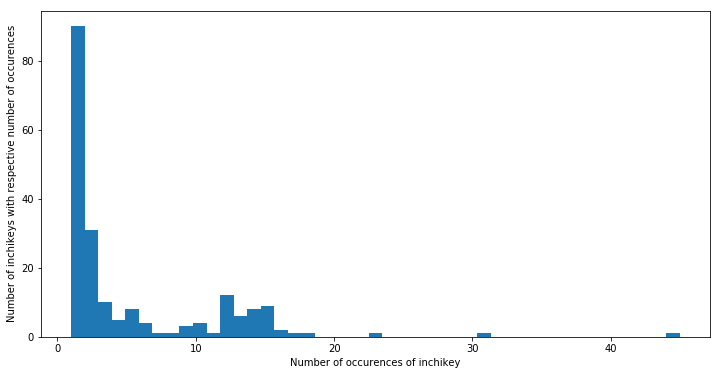

In [14]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,6))
plt.hist(inchikeys_pd.str[:14][selected_spectra].value_counts(), 45)
plt.xlabel('Number of occurences of inchikey')
plt.ylabel('Number of inchikeys with respective number of occurences')

## Train new Spec2Vec model on dataset without the selected spectra

In [36]:
# Remove selected spectra from corpus
MS_docs_removedpart = [MS_documents[x] for x in range(len(MS_documents)) if x not in selected_spectra]
MS_docs_intensity_removedpart = [MS_documents_intensity[x] for x in range(len(MS_documents)) if x not in selected_spectra]   
print("Modified corpus consists of", len(MS_docs_removedpart), "documents.")

MS_library = SimilarityMeasures(MS_docs_removedpart, MS_docs_intensity_removedpart)
MS_library.preprocess_documents(1, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_library.dictionary))

# Train new model based on reduced corpus
file_model_word2vec = PATH_SAVE_MODEL + 'S2V_allGNPS_pos_unknownmatching_d300_w500_neg5_minmax10_1000_dec2_exp08.model'
MS_library.build_model_word2vec(file_model_word2vec, sg=0, negative=5, size=300, window=500, 
                             min_count=1, workers=4, iterations= [10,5], 
                             use_stored_model=True)
print("Learning rate droped from", MS_measure.model_word2vec.alpha, "to", MS_measure.model_word2vec.min_alpha_yet_reached)

Modified corpus consists of 89232 documents.


Preprocess documents...
Number of unique words:  145568


No saved word2vec model found with given filename!
Calculating new word2vec model...
 Epoch 1 of 15.Change in loss after epoch 1: 6965052.0
 Epoch 2 of 15.Change in loss after epoch 2: 4970318.0
 Epoch 3 of 15.Change in loss after epoch 3: 4495444.0
 Epoch 4 of 15.Change in loss after epoch 4: 3737214.0
 Epoch 5 of 15.Change in loss after epoch 5: 3556258.0
 Epoch 6 of 15.Change in loss after epoch 6: 3440130.0
 Epoch 7 of 15.Change in loss after epoch 7: 3270988.0
 Epoch 8 of 15.Change in loss after epoch 8: 3154664.0
 Epoch 9 of 15.Change in loss after epoch 9: 1914572.0
 Epoch 10 of 15.Change in loss after epoch 10: 1871908.0
Saving model with name: C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\Spec2Vec\models_trained\S2V_allGNPS_pos_unknownmatching_d300_w500_neg5_minmax10_1000_dec2_exp08_iter_10.model
 Epoch 11 of 15.Change in loss after epoch 11: 1832752.0

In [15]:
# or load pretrained
MS_docs_removedpart = [MS_documents[x] for x in range(len(MS_documents)) if x not in selected_spectra]
MS_docs_intensity_removedpart = [MS_documents_intensity[x] for x in range(len(MS_documents)) if x not in selected_spectra]   
print("Modified corpus consists of", len(MS_docs_removedpart), "documents.")

MS_library = SimilarityMeasures(MS_docs_removedpart, MS_docs_intensity_removedpart)
MS_library.preprocess_documents(1, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_library.dictionary))

# Train new model based on reduced corpus
file_model_word2vec = PATH_SAVE_MODEL + 'S2V_allGNPS_pos_unknownmatching_d300_w500_neg5_minmax10_1000_dec2_exp08_iter_15.model'
MS_library.build_model_word2vec(file_model_word2vec, sg=0, negative=5, size=300, window=500, 
                             min_count=1, workers=4, iterations= [10,5], 
                             use_stored_model=True)

Modified corpus consists of 89232 documents.
Preprocess documents...
Number of unique words:  145568
Load stored word2vec model ...


## Calculate Spec2Vec spectra vectors for all library spectra

In [16]:
MS_library.get_vectors_centroid(method = 'ignore', 
                                 tfidf_weighted = False, 
                                 weighting_power = 0.5, 
                                 tfidf_model = None,
                                 extra_epochs = 1)

All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  89232  of  89232  documents.ocuments. 89232  documents. 89232  documents. Calculated centroid vectors for  3380  of  89232  documents. 89232  documents.4280  of  89232  documents.  documents.5540  of  89232  documents. of  89232  documents.6150  of  89232  documents. 89232  documents.8380  of  89232  documents. of  89232  documents. Calculated centroid vectors for  8710  of  89232  documents.  of  89232  documents. 89232  documents.89232  documents.  of  89232  documents.10580  of  89232  documents.11450  of  89232  documents.  of  89232  documents. Calculated centroid vectors for  11730  of  89232  documents.13450  of  89232  documents.89232  documents. of  89232  documents. documents. of  89232  documents. 89232  documents.17610  of  89232  documents. 89232  documents.  of  89232  documents. 89232  documents. Calculated centroid vectors for  20550  of  89232  documents. of 

In [17]:
MS_library.vectors_centroid.shape[0]

89232

### Save MS_library object (including all computed S2V spectra vectors)

In [18]:
MS_library.save(PATH_COMPUTED + 'unkown_spectra_search_191202.obj')

In [15]:
MS_library = SimilarityMeasures([])
MS_library.load(PATH_COMPUTED + 'unkown_spectra_search_191202.obj')

### Select metadata for library spectra

In [16]:
library_spectra_IDs = [x for x in range(len(spectra)) if x not in selected_spectra]
library_spectra_metadata = spectra_metadata.loc[library_spectra_IDs]

library_spectra_metadata.shape

(89232, 10)

In [17]:
spectra_unknown = [spectra[x] for x in selected_spectra]
spectra_library = [spectra[x] for x in range(len(spectra)) if x not in selected_spectra]
len(spectra_unknown), len(spectra_library)

(994, 89232)

In [18]:
def library_matching(spectra_query, 
                     spectra_library,
                     library_spectra_metadata, 
                     MS_library, 
                     top_n = 10,
                     mz_ppm = 10,
                     spectra_vectors = None,
                     ignore_non_annotated = True,
                     cosine_tol = 0.005):
    """
    Function to select potential spectra matches.
    Suitable candidates will be selected by 1) top_n Spec2Vec similarity, and 2) same precursor mass 
    (within given mz_ppm tolerance(s)). 
    For later matching routines, additional scores (cosine, modified cosine) are added as well.
    
    Args:
    --------
    """
    
    # Check input data
    if len(spectra_library) != library_spectra_metadata.shape[0]:
        print("Warning! Library spectra metadata input does not match given library spectra.")
    if len(spectra_library) != len(MS_library.corpus):
        print("Warning! Library spectra input does not match dimension of given MS_library object.")
    if MS_library.vectors_centroid.shape[0] != library_spectra_metadata.shape[0]:
        print("Warning! Number of found Spec2Vec spectral vectors does not agree with library metadata dimension.")
    if spectra_vectors is None:
        print("No Spec2Vec spectra vectors found for query data. Please do so using the vectorize_spectra() function")

    
    # Initializations
    found_matches = []
    S2V_matches = []
    
    if ignore_non_annotated:
        # Get array of all IDs for spectra with smiles
        annotated_spectra_IDs = np.where(library_spectra_metadata['smiles'].isna().values == False)[0]
    
    # --------------------------------------------------------------------------
    # 1. Search for top-n Spec2Vec matches -------------------------------------
    # --------------------------------------------------------------------------
    
    #Check if Spec2Vec vectors are present for library
    if len(MS_library.vectors_centroid) == 0:
        print("Apparently Spec2Vec spectra vectors have not yet been derived for library data.")
        print("Spec2Vec spectra vectors will be calculated using default parameters.")
        MS_library.get_vectors_centroid(method = 'ignore', 
                                         extra_weights = None, 
                                         tfidf_weighted = False, 
                                         weight_method = 'sqrt', 
                                         tfidf_model = None,
                                         extra_epochs = 1)
    else:
        print("Spec2Vec spectra vectors found for library data.")

    if ignore_non_annotated:
        library_vectors = MS_library.vectors_centroid[annotated_spectra_IDs]
    else:
        library_vectors = MS_library.vectors_centroid
    M_spec2vec_similairies = 1 - spatial.distance.cdist(library_vectors, spectra_vectors, 'cosine')

    # Select top_n similarity values:
    Top_n = np.argpartition(M_spec2vec_similairies, -top_n, axis=0)[-top_n:,:]

    # Sort selected values by order
    for i in range(len(spectra_query)):
        Top_n_sorted = Top_n[:,i][np.argsort(M_spec2vec_similairies[Top_n[:,i],i])][::-1]
        if ignore_non_annotated:
            Top_n_corrected_IDs = annotated_spectra_IDs[Top_n_sorted]
        else:
            Top_n_corrected_IDs = Top_n_sorted

        S2V_match = list(zip(Top_n_corrected_IDs, M_spec2vec_similairies[Top_n_sorted,i]))
        S2V_matches.append(S2V_match)
                  
    # --------------------------------------------------------------------------
    # 2. Search for precursor mz based matches --------------------------------
    # --------------------------------------------------------------------------
    if ignore_non_annotated:
        library_masses = library_spectra_metadata['precursor_mz'].values[annotated_spectra_IDs]
    else:
        library_masses = library_spectra_metadata['precursor_mz'].values
        
    if not isinstance(mz_ppm, list):
        mz_ppm = [mz_ppm]
    mz_ppm = sorted(mz_ppm)[::-1]
    
    mass_matches_ppms = []
    for ppm in mz_ppm:
        library_masses_tol = library_masses * ppm/1e6
        mass_matches = []
            
        # Get precursor mz for query spectra
        precursor_mz_query = []

        for spec in spectra_query:
            mass = spec.precursor_mz
            mass_match = np.where(((library_masses + library_masses_tol) > mass) & 
                                  ((library_masses - library_masses_tol) < mass))[0]
            if ignore_non_annotated:
                mass_matches.append(annotated_spectra_IDs[mass_match])
            else:
                mass_matches.append(mass_match)
        mass_matches_ppms.append(mass_matches)
    
    # --------------------------------------------------------------------------
    # 3. Combine found matches -------------------------------------------------
    # --------------------------------------------------------------------------
    for i in range(len(spectra_query)):
        IDs = list(mass_matches_ppms[0][i])
        mass_match_lst = len(mass_matches_ppms[0][i]) * [1]
        s2v_match_lst = len(mass_matches_ppms[0][i]) * [0]
        
        # Add Spec2Vec top_n matches to list
        a, _ = list(zip(*S2V_matches[i]))
        for match in a:
            if match in IDs:
                s2v_match_lst[IDs.index(match)] = 1
            else:
                IDs.append(match)
                mass_match_lst.append(0)
                s2v_match_lst.append(1)
                
        # Add Spec2Vec scores for all entries
        # And calculate if found inchikey is a match
        inchikey_match = []
        s2v_score_lst = []
        for m, idx in enumerate(IDs):
            #if s2v_match_lst[m] == 0:
            if ignore_non_annotated:
                idx_uncorrected = int(np.where(annotated_spectra_IDs == idx)[0])
                s2v_score_lst.append(M_spec2vec_similairies[idx_uncorrected,i])
            else:
                s2v_score_lst.append(M_spec2vec_similairies[idx,i])
                
            inchikey_match.append(1 * (spectra_library[idx].inchikey[:14] == spectra_query[i].inchikey[:14]))
        matches_df = pd.DataFrame(list(zip(IDs, mass_match_lst, s2v_match_lst, s2v_score_lst, inchikey_match)),
                                       columns = ['spectra_ID', 
                                                  'mass_match'+ str(int(mz_ppm[0])) + 'ppm', 
                                                  'S2V_top_n', 'S2V_similarity', 'inchikey_match'])
        # Add mass matches from other ppms (if given)
        for m, ppm in enumerate(mz_ppm[1:]):
            col_name = 'mass_match_' + str(int(ppm)) + 'ppm'
            matches_df[col_name] = 0
            matches_df.loc[matches_df['spectra_ID'].isin(mass_matches_ppms[m+1][i]), col_name] = 1        
        
        found_matches.append(matches_df) 
    
    # --------------------------------------------------------------------------
    # 4. Add additonal similarity measures (cosine + mod.cosine) ---------------
    # --------------------------------------------------------------------------   
    for i in range(len(spectra_query)): 
        cosine_scores = []
        for j in found_matches[i]['spectra_ID']:
            cosine_score = cosine_check(spectra_query[i],
                                        spectra_library[j],
                                        tol = cosine_tol,
                                        mod_cosine = False)
            cosine_scores.append(cosine_score)
        a, b = list(zip(*cosine_scores))
        found_matches[i]['cosine_score'] = a
        found_matches[i]['cosine_matches'] = b
                
    for i in range(len(spectra_query)): 
        cosine_scores = []
        for j in found_matches[i]['spectra_ID']:
            cosine_score = cosine_check(spectra_query[i],
                                        spectra_library[j],
                                        tol = cosine_tol,
                                        mod_cosine = True)
            cosine_scores.append(cosine_score)
        a, b = list(zip(*cosine_scores))
        found_matches[i]['modcosine_score'] = a
        found_matches[i]['modcosine_matches'] = b
                
    return found_matches


def cosine_check(spectra1,
                 spectra2,
                 tol = 0.005,
                 mod_cosine = False):

    if mod_cosine:
        mass_shift = spectra1.parent_mz - spectra2.parent_mz
    else:
        mass_shift = None
    spec1 = np.array(spectra1.peaks, dtype=float)
    spec2 = np.array(spectra2.peaks, dtype=float)
    cosine_score = MS_sim_classic.cosine_score_greedy(spec1, 
                                                    spec2,
                                                    mass_shift = mass_shift,
                                                    tol = tol, 
                                                    min_intens = 0,
                                                    use_numba = True)
    return (cosine_score[0], len(cosine_score[1]))
        

In [19]:
spectra_vectors = MS_functions.vectorize_spectra(spectra_unknown,
                                                  MS_library,
                                                  num_decimals = 2,
                                                  min_loss = 5.0, 
                                                  max_loss = 500.0,
                                                  peak_loss_words = ['peak_', 'loss_'],
                                                  weighting_power = 0.5)

  Created documents for  994  of  994  spectra.
 ----------------------------------------
Not all 'words' of the given documents are present in the trained word2vec model!
33  out of  55496  'words' were not found in the word2vec model.
'Words'missing in the pretrained word2vec model will be ignored.
Removing missing 'words' from corpus...
----- Deriving Spec2Vec spectra vectors -----
  Calculated Spec2Vec spectra vectors for  994  of  994  documents. 994  documents.

In [20]:
spectra_vectors[:,:].shape, MS_library.vectors_centroid.shape

((994, 300), (89232, 300))

In [21]:
import pandas as pd

found_matches = library_matching(spectra_unknown, 
                                  spectra_library,
                                  library_spectra_metadata, 
                                  MS_library, 
                                  top_n = 10,
                                  mz_ppm = [2, 10, 20],
                                  spectra_vectors = spectra_vectors,
                                  ignore_non_annotated = True,
                                  cosine_tol = 0.05)

Spec2Vec spectra vectors found for library data.


In [31]:
found_matches[120]

,spectra_ID,mass_match20ppm,S2V_top_n,S2V_similarity,inchikey_match,mass_match_10ppm,mass_match_2ppm,cosine_score,cosine_matches,modcosine_score,modcosine_matches
0,27799,1,0,0.529763,0,1,1,0.000868,1,0.000868,1
1,27800,1,0,0.487407,0,1,1,0.001939,3,0.001939,3
2,27801,1,0,0.532826,0,1,1,0.000391,1,0.000391,1
3,27802,1,0,0.606895,0,1,1,0.000000,0,0.000000,0
4,29326,1,0,0.540196,0,1,1,0.001668,2,0.001668,2
5,29327,1,0,0.593158,0,1,1,0.000000,0,0.000000,0
6,29328,1,0,0.608804,0,1,1,0.020428,3,0.020428,3
7,29329,1,0,0.614740,0,1,1,0.122249,1,0.122249,1
8,32294,1,0,0.088468,0,1,1,0.000038,1,0.000038,1
9,28858,0,1,0.780471,0,0,0,0.022819,3,0.022819,3


In [24]:
ID = 20#80

match_IDs = found_matches[ID][found_matches[ID]['mass_match_10ppm']==1]['spectra_ID'].values.tolist()
[spectra_library[x].inchikey for x in match_IDs]

['BMKQPAJRQUUYGC-UHFFFAOYSA-N',
 'BMKQPAJRQUUYGC-UHFFFAOYSA-N',
 'BMKQPAJRQUUYGC-UHFFFAOYSA-N',
 'DDNPCXHBFYJXBJ-UHFFFAOYSA-N',
 'DDNPCXHBFYJXBJ-UHFFFAOYSA-N',
 'DDNPCXHBFYJXBJ-UHFFFAOYSA-N']

In [59]:
ID = 90

print("mass matching")

match_IDs = found_matches[ID][found_matches[ID]['mass_match50ppm']==1]['spectra_ID'].values.tolist()
if len(match_IDs) > 0:
    fingerprint_query, _ = MS_functions.get_mol_fingerprints([spectra_unknown[ID]], method = "morgan3", nBits = 2048)
    fingerprint_matches, _ = MS_functions.get_mol_fingerprints([spectra_library[x] for x in match_IDs], method = "morgan3", nBits = 2048)

    # calculate similarities
    Mtest = MS_sim_classic.mol_sim_matrix(fingerprint_query,
                       fingerprint_matches,
                       method = 'cosine',
                       filename = None,
                       max_size = 1000)

    print(Mtest)
    
    
print('\n')
print("Spec2Vec matching")

match_IDs = found_matches[ID][found_matches[ID]['S2V_top_n']==1]['spectra_ID'].values.tolist()
if len(match_IDs) > 0:
    fingerprint_query, _ = MS_functions.get_mol_fingerprints([spectra_unknown[ID]], method = "morgan3", nBits = 2048)
    fingerprint_matches, _ = MS_functions.get_mol_fingerprints([spectra_library[x] for x in match_IDs], method = "morgan3", nBits = 2048)

    # calculate similarities
    Mtest = MS_sim_classic.mol_sim_matrix(fingerprint_query,
                       fingerprint_matches,
                       method = 'cosine',
                       filename = None,
                       max_size = 1000)

    print(Mtest)
    
    
print('\n')
print("Spec2Vec + mod.cosine matching")

match_IDs = found_matches[ID][found_matches[ID]['S2V_top_n']==1].sort_values(by=['cosine_score', 'modcosine_score'], ascending=False)['spectra_ID'].values.tolist()
if len(match_IDs) > 0:
    fingerprint_query, _ = MS_functions.get_mol_fingerprints([spectra_unknown[ID]], method = "morgan3", nBits = 2048)
    fingerprint_matches, _ = MS_functions.get_mol_fingerprints([spectra_library[x] for x in match_IDs], method = "morgan3", nBits = 2048)

    # calculate similarities
    Mtest = MS_sim_classic.mol_sim_matrix(fingerprint_query,
                       fingerprint_matches,
                       method = 'cosine',
                       filename = None,
                       max_size = 1000)

    print(Mtest)

mass matching
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
[[0.2074131  0.22222832 0.1694113  0.20184778 0.16806139 0.16296743
  0.12738595 0.16058822 0.08956222 0.14969624 0.14969624 0.1694113
  0.1694113  0.1694113  0.20184778 0.20184778 0.20184778 0.18190172
  0.18190172 0.18190172 0.16296743 0.16296743 0.16296743]]


Spec2Vec matching
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix con

In [61]:
mol_sim_matches_s2v = []

for ID in range(len(spectra_unknown)):
    match_IDs = found_matches[ID][found_matches[ID]['S2V_top_n']==1]['spectra_ID'].values.tolist()
    if len(match_IDs) > 0:
        fingerprint_query, _ = MS_functions.get_mol_fingerprints([spectra_unknown[ID]], method = "morgan3", nBits = 2048)
        fingerprint_matches, _ = MS_functions.get_mol_fingerprints([spectra_library[x] for x in match_IDs], method = "morgan3", nBits = 2048)

        # calculate similarities
        Mtest = MS_sim_classic.mol_sim_matrix(fingerprint_query,
                           fingerprint_matches,
                           method = 'cosine',
                           filename = None,
                           max_size = 1000)

        mol_sim_matches_s2v.append(Mtest)

---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 ou

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 ou

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from in

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from in

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 ou

---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular si

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully c

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from in

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular si

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
No proper molecule generated for spectrum 0
No proper molecule generated for spectrum 1
No proper molecule generated for spectrum 2
---- (2) Generating fingerprints from molecules...
Problem with molecule from spectrum 0
Problem with molecule from spectrum 1
Problem with molecule from spectrum 2
 C

Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles

---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from in

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular si

---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 ou

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully c

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

In [65]:
mol_sim_matches_s2v_arr = np.array(mol_sim_matches_s2v)
np.mean(np.nan_to_num(mol_sim_matches_s2v_arr), axis = 0)

array([[0.40567453, 0.39187748, 0.36834293, 0.35744087, 0.34860233,
        0.34585692, 0.34176485, 0.326268  , 0.32744904, 0.32621783]])

In [91]:
mol_sim_matches_s2v_arr.shape

(994, 1, 10)

(array([15., 36., 80., 97., 87., 81., 44., 46., 61., 36., 32., 21., 28.,
        29., 21., 18., 19., 44., 56., 13., 23., 55.,  8., 12., 31.]),
 array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
        0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
        0.88, 0.92, 0.96, 1.  ]),
 <a list of 25 Patch objects>)

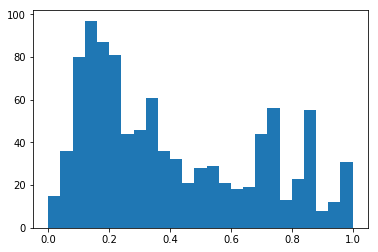

In [94]:
plt.hist(mol_sim_matches_s2v_arr[:,0,0], 25)

## Use precursor mz to search similar spectra

In [25]:
mol_sim_matches_mass = []

for ID in range(len(spectra_unknown)):
    match_IDs = found_matches[ID][found_matches[ID]['mass_match_10ppm']==1]['spectra_ID'].values.tolist()
    if len(match_IDs) > 0:
        fingerprint_query, _ = MS_functions.get_mol_fingerprints([spectra_unknown[ID]], method = "morgan3", nBits = 2048)
        fingerprint_matches, _ = MS_functions.get_mol_fingerprints([spectra_library[x] for x in match_IDs], method = "morgan3", nBits = 2048)

        # calculate similarities
        Mtest = MS_sim_classic.mol_sim_matrix(fingerprint_query,
                           fingerprint_matches,
                           method = 'cosine',
                           filename = None,
                           max_size = 1000)

        mol_sim_matches_mass.append(Mtest)

---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 ou

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 ou

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from in

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 ou

---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular si

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 ou

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

In [45]:
mol_sim_matches_mass[400:450]

[array([[0.2316945 , 0.22710604, 0.22710604, 0.33485541, 0.28896025,
         0.25537696, 0.18766297, 0.2955414 , 0.64519859, 0.2316945 ,
         0.53679609, 0.20064309, 0.20064309, 0.20064309, 0.20064309,
         0.20064309, 0.20064309, 0.20064309, 0.20064309, 0.33485541,
         0.33485541, 0.33485541, 0.59389501, 0.59389501, 0.53679609,
         0.53679609, 0.53679609, 0.28896025, 0.28896025, 0.28896025,
         0.18227439, 0.18227439, 0.18227439, 0.53679609, 0.53679609,
         0.53679609]]),
 array([[0.2316945 , 0.22710604, 0.22710604, 0.33485541, 0.28896025,
         0.25537696, 0.18766297, 0.2955414 , 0.64519859, 0.2316945 ,
         0.53679609, 0.20064309, 0.20064309, 0.20064309, 0.20064309,
         0.20064309, 0.20064309, 0.20064309, 0.20064309, 0.33485541,
         0.33485541, 0.33485541, 0.59389501, 0.59389501, 0.53679609,
         0.53679609, 0.53679609, 0.28896025, 0.28896025, 0.28896025,
         0.18227439, 0.18227439, 0.18227439, 0.53679609, 0.53679609,
         0

In [35]:
len(mol_sim_matches_mass)

617

In [46]:
mol_sim_matches_mass_mean = np.zeros((10))
mol_sim_matches_mass_counts = np.zeros((10))
top1_lst = []

for matches in mol_sim_matches_mass:
    matches = np.nan_to_num(matches[0])
    high = min(len(matches),10)
    if high > 0:
        top1_lst.append(matches[0])
        mol_sim_matches_mass_mean[:high] = mol_sim_matches_mass_mean[:high] + np.array(matches[:high])
        mol_sim_matches_mass_counts[:high] = mol_sim_matches_mass_counts[:high] + np.ones(high)

mol_sim_matches_mass_arr1 = np.array(top1_lst)    
    
mol_sim_matches_mass_mean/mol_sim_matches_mass_counts

array([0.32820284, 0.32393535, 0.32938486, 0.34720183, 0.33167217,
       0.35090474, 0.35584046, 0.34860265, 0.37193793, 0.34817626])

(array([ 44.,  69., 116.,  64.,  63.,  16.,  25.,  10.,  30.,  21.,  29.,
          8.,   1.,   9.,   1.,   9.,   6.,  47.,  18.,   0.,   2.,   3.,
          1.,   9.,  16.]),
 array([0.06745406, 0.10432808, 0.1412021 , 0.17807612, 0.21495013,
        0.25182415, 0.28869817, 0.32557219, 0.3624462 , 0.39932022,
        0.43619424, 0.47306826, 0.50994228, 0.54681629, 0.58369031,
        0.62056433, 0.65743835, 0.69431236, 0.73118638, 0.7680604 ,
        0.80493442, 0.84180843, 0.87868245, 0.91555647, 0.95243049,
        0.98930451]),
 <a list of 25 Patch objects>)

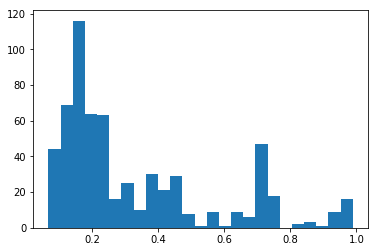

In [47]:
plt.hist(mol_sim_matches_mass_arr1, 25)

(array([ 10.,  72., 130., 170., 146.,  72.,  43.,  13.,  34.,  11.,  22.,
         15.,   1.,   3.,   3.,  12.,   2.,   4.,  24.,   0.,   0.,   5.,
          4.,   5.,  11.]),
 array([0.02067246, 0.05944354, 0.09821462, 0.1369857 , 0.17575678,
        0.21452786, 0.25329894, 0.29207003, 0.33084111, 0.36961219,
        0.40838327, 0.44715435, 0.48592543, 0.52469652, 0.5634676 ,
        0.60223868, 0.64100976, 0.67978084, 0.71855192, 0.757323  ,
        0.79609409, 0.83486517, 0.87363625, 0.91240733, 0.95117841,
        0.98994949]),
 <a list of 25 Patch objects>)

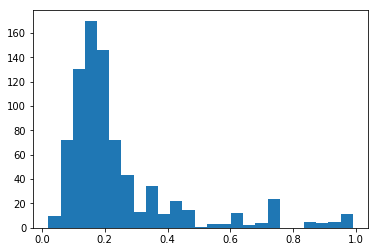

In [97]:
plt.hist(mol_sim_matches_mass_arr1, 25) # for 50ppm search

In [ ]:
S2V_similarity

In [ ]:
mol_sim_matches_s2v_thres = []

for ID in range(len(spectra_unknown)):
    match_IDs = found_matches[ID][(found_matches[ID]['S2V_top_n']==1)
                                  & (found_matches[ID]['S2V_similarity'] > 0.5)
                                  & (found_matches[ID]['modcosine_score'] > 0.5)]['spectra_ID'].values.tolist()
    if len(match_IDs) > 0:
        fingerprint_query, _ = MS_functions.get_mol_fingerprints([spectra_unknown[ID]], method = "morgan3", nBits = 2048)
        fingerprint_matches, _ = MS_functions.get_mol_fingerprints([spectra_library[x] for x in match_IDs], method = "morgan3", nBits = 2048)

        # calculate similarities
        Mtest = MS_sim_classic.mol_sim_matrix(fingerprint_query,
                           fingerprint_matches,
                           method = 'cosine',
                           filename = None,
                           max_size = 1000)

        mol_sim_matches_s2v_thres.append(Mtest)

---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 ou

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from in

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully c

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 ou

 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints f

In [ ]:
len(mol_sim_matches_s2v), len(mol_sim_matches_s2v_thres)

In [ ]:
mol_sim_matches_s2v_thres[0]

In [ ]:
plt.hist([x[0] for x in mol_sim_matches_s2v_thres], 25)

KeyboardInterrupt: 

In [282]:
ID = 80

print("mass matching")
if len(mass_matches[ID]) > 0:
    fingerprint_query, _ = MS_functions.get_mol_fingerprints([spectra_unknown[ID]], method = "morgan3", nBits = 2048)
    fingerprint_matches, _ = MS_functions.get_mol_fingerprints([spectra_library[x] for x in mass_matches[ID]], method = "morgan3", nBits = 2048)

    # calculate similarities
    Mtest = MS_sim_classic.mol_sim_matrix(fingerprint_query,
                       fingerprint_matches,
                       method = 'cosine',
                       filename = None,
                       max_size = 1000)

    print(Mtest)

print('\n')
print("Spec2Vec matching")
if len(S2V_matches[ID]) > 0:
    S2V_IDs, _ = list(zip(*S2V_matches[ID]))
    fingerprint_query, _ = MS_functions.get_mol_fingerprints([spectra_unknown[ID]], method = "morgan3", nBits = 2048)
    fingerprint_matches, _ = MS_functions.get_mol_fingerprints([spectra_library[x] for x in S2V_IDs], method = "morgan3", nBits = 2048)

    # calculate similarities
    Mtest = MS_sim_classic.mol_sim_matrix(fingerprint_query,
                       fingerprint_matches,
                       method = 'cosine',
                       filename = None,
                       max_size = 1000)

    print(Mtest)

print('\n')
print("Spec2Vec + mass matching:")
if len(multiple_matches[ID]) > 0:
    fingerprint_query, _ = MS_functions.get_mol_fingerprints([spectra_unknown[ID]], method = "morgan3", nBits = 2048)
    fingerprint_matches, _ = MS_functions.get_mol_fingerprints([spectra_library[x] for x in multiple_matches[ID]], method = "morgan3", nBits = 2048)

    # calculate similarities
    Mtest = MS_sim_classic.mol_sim_matrix(fingerprint_query,
                       fingerprint_matches,
                       method = 'cosine',
                       filename = None,
                       max_size = 1000)

    print(Mtest)
else:
    print("no multi matches found")

mass matching
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
[[0.12738595 0.08956222]]


Spec2Vec matching
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
---- (1) Generating RDkit molecules from inchi or smiles...
---- (2) Generating fingerprints from molecules...
 Calculated submatrix 1 out of 1----------------------------------------
Succesfully calculated matrix containing all-vs-all molecular similarity values.
[[0.71649772 0.53249814 0.53249814 0.53249814 0.48058066 0.50020421
  0.48058066 0.45834925 0.47752932 0.37896191]]


Spec2Vec + mass matching:
no multi matches found


In [283]:
S2V_matches[ID], S2V_IDs

([(22135, 0.6245102038262917),
  (3189, 0.6145014865453571),
  (6312, 0.611620187474343),
  (22083, 0.5888185401103134),
  (3188, 0.5812778582815105),
  (22385, 0.5698088298834295),
  (5796, 0.5656801974134198),
  (22532, 0.5494818500372012),
  (22136, 0.5442173883551121),
  (22302, 0.5296028194874521)],
 (22135, 3189, 6312, 22083, 3188, 22385, 5796, 22532, 22136, 22302))

In [111]:
library_spectra_metadata.iloc[multiple_matches[0]]['smiles']

38147    CN1CCc2cc3c(cc2[C@H]1[C@H]1c2ccc4c(c2C(=O)O1)O...
38148    CN1CCc2cc3c(cc2[C@H]1[C@H]1c2ccc4c(c2C(=O)O1)O...
38146    CN1CCc2cc3c(cc2[C@H]1[C@H]1c2ccc4c(c2C(=O)O1)O...
Name: smiles, dtype: object

In [118]:
ID = 20

print("SMILES:", spectra_unkown[ID].smiles, '\n', 
      "TITLE:", spectra_unkown[ID].metadata['title'])
print(library_spectra_metadata.iloc[multiple_matches[ID]]['smiles'])

SMILES: COc1cc(cc(c1O)OC)/C=C\1/C(=O)c2c(cc(cc2O1)O)O 
 TITLE: (2Z)-4,6-dihydroxy-2-[(4-hydroxy-3,5-dimethoxyphenyl)methylidene]-1-benzofuran-3-one
46431       COc1c(cc2c(c1O)c(=O)c(c(c1ccc(cc1)O)o2)OC)O
46432       COc1c(cc2c(c1O)c(=O)c(c(c1ccc(cc1)O)o2)OC)O
46433       COc1c(cc2c(c1O)c(=O)c(c(c1ccc(cc1)O)o2)OC)O
41949    CC(C(c1cc2c(c(c1)O)C(=O)c1c(cc(cc1O)O)C2=O)O)O
41950    CC(C(c1cc2c(c(c1)O)C(=O)c1c(cc(cc1O)O)C2=O)O)O
41951    CC(C(c1cc2c(c(c1)O)C(=O)c1c(cc(cc1O)O)C2=O)O)O
Name: smiles, dtype: object


In [237]:
S2V_matches[10]

[(22819, 0.40550852877818655),
 (3591, 0.3775137669621267),
 (8845, 0.36788390385247993),
 (3585, 0.3659787550894058),
 (1024, 0.363666137448299),
 (1442, 0.36110087298294535),
 (8919, 0.3589966150467325),
 (3587, 0.35744702588861577),
 (1284, 0.357204208571382),
 (1272, 0.3529747684847194)]

In [241]:
library_spectra_metadata.iloc[8845]

doc_ID                                                           8974
gnps_ID                                            CCMSLIB00000847581
name                NCGC00347590-02!9,11,12a-trihydroxy-2,3-dimeth...
title                                                             NaN
precursor_mz                                                  411.143
num_peaks_losses                                                  372
inchi               "InChI=1S/C23H24O8/c1-11(2)5-6-12-14(24)8-15(2...
inchikey                                  LAUJMTGOOIBBOB-UHFFFAOYSA-N
smiles              COC1=CC2=C(C=C1OC)C3(O)C(CO2)OC4=C(CC=C(C)C)C(...
charge                                                              1
Name: 8974, dtype: object

In [229]:
spectra[8845].

True

In [239]:
S2V_IDs

(22819, 3591, 8845, 3585, 1024, 1442, 8919, 3587, 1284, 1272)